Compares annotations from different experts



In [1]:
# @author: barisbozkurt
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# This code consumes data files created by the dataProcessPipeline.py script

# Unpacking data from different annotators with and without manually corrected onsets
data_packages = ['rhythm_data4ML_0.zip','rhythm_data4ML_1.zip','rhythm_data4ML_2.zip']

data_folders = ['Expert0','Expert1','Expert2']

#Unzipping packages into folders
for data_folder, data_zip_file in zip(data_folders, data_packages):
  if not os.path.exists(data_folder):  # create folder if not exists
      os.mkdir(data_folder)
  zip_ref = zipfile.ZipFile(data_zip_file, 'r')
  zip_ref.extractall(data_folder)
  zip_ref.close()

In [3]:
def read_tabular_data(data_folder, train_file_path='trainData.csv', test_file_path='testData.csv'):
  '''Reads tabular data and converts to dictionaries'''
  trainDF = pd.read_csv(os.path.join(data_folder, train_file_path))
  testDF = pd.read_csv(os.path.join(data_folder, test_file_path))
  y_train = trainDF[['Per_file','grade']].to_dict(orient='records')
  y_test = testDF[['Per_file','grade']].to_dict(orient='records')
  
  # Conversion from DF to dictionary
  y_train_dict = {}
  for k in range(len(y_train)):
    y_train_dict[y_train[k]['Per_file']] = y_train[k]['grade']
  
  y_test_dict = {}
  for k in range(len(y_test)):
    y_test_dict[y_test[k]['Per_file']] = y_test[k]['grade']
  
  return y_train_dict, y_test_dict

########################################
COMPARING ANNOTATIONS OF  Expert0 and Expert1 over files of Expert0
MAE on train data Expert0 vs Expert1: 0.3993610223642173
              precision    recall  f1-score   support

           1       0.61      0.80      0.69       205
           2       0.38      0.45      0.41       175
           3       0.72      0.35      0.47       258
           4       0.83      0.92      0.88       301

    accuracy                           0.65       939
   macro avg       0.63      0.63      0.61       939
weighted avg       0.67      0.65      0.64       939

MAE on test data Expert0 vs Expert1: 0.44
              precision    recall  f1-score   support

           1       0.51      0.84      0.64        25
           2       0.62      0.40      0.49        25
           3       0.78      0.28      0.41        25
           4       0.74      1.00      0.85        25

    accuracy                           0.63       100
   macro avg       0.66      0.

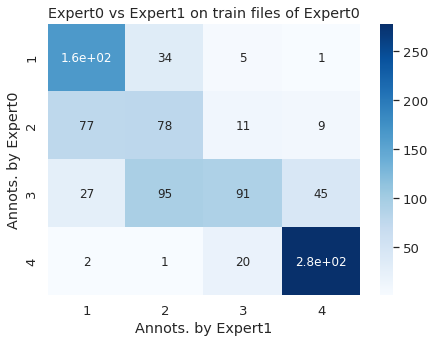

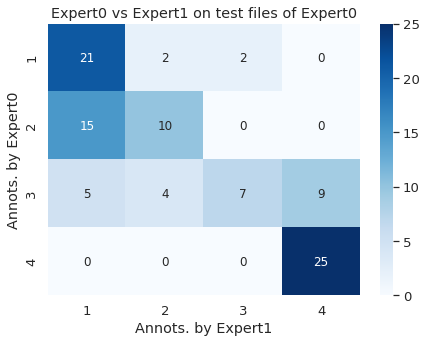

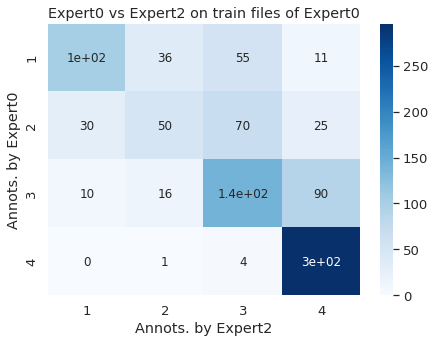

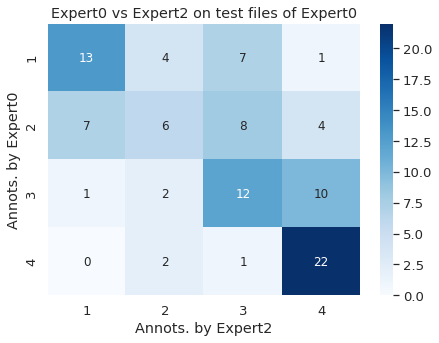

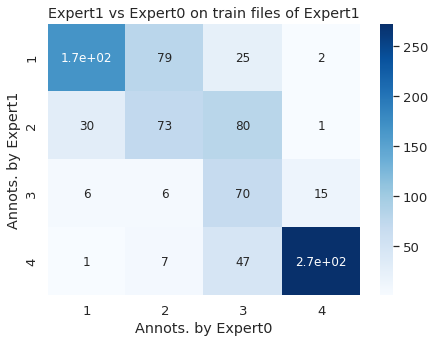

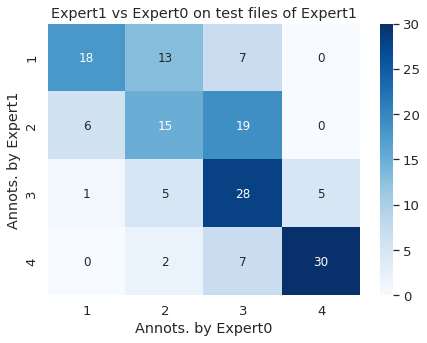

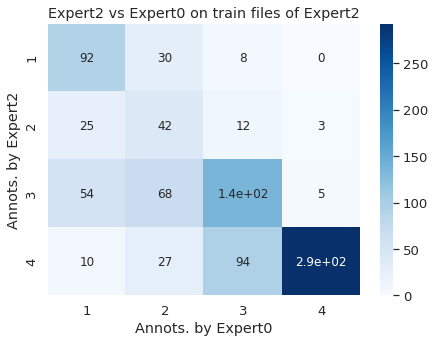

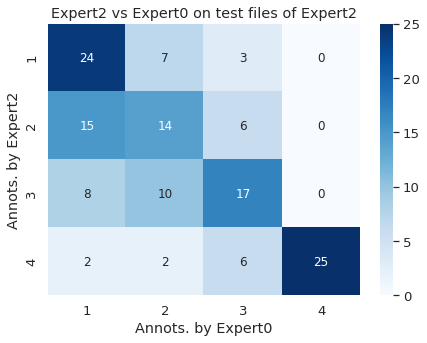

In [4]:
# Comparison combinations
data_folder_combinations = [(data_folders[0],data_folders[1]),
                            (data_folders[0],data_folders[2]),
                            (data_folders[1],data_folders[0]),
                            (data_folders[2],data_folders[0]),]
labels = np.arange(1,5)
labels_str = [str(val) for val in labels]

for data_folder_a, data_folder_b in data_folder_combinations:
  print('#'*40)
  print('COMPARING ANNOTATIONS OF ', data_folder_a, 'and', data_folder_b, 'over files of', data_folder_a)

  y_train_dict_a, y_test_dict_a = read_tabular_data(data_folder_a)
  y_all_dict_a = {**y_train_dict_a, **y_test_dict_a} # merge two dictionaries
  y_train_dict_b, y_test_dict_b = read_tabular_data(data_folder_b)
  y_all_dict_b = {**y_train_dict_b, **y_test_dict_b} # merge two dictionaries

  # Comparing annotations for train files for annotator-a and annotator-b
  y_train_a = np.array(list(y_train_dict_a.values()))
  y_train_b = []
  for train_files_a in y_train_dict_a.keys():
    y_train_b.append(y_all_dict_b[train_files_a])
  y_train_b = np.array(y_train_b)

  conf_mat = pd.DataFrame(confusion_matrix(y_train_a, y_train_b),
                            columns=labels, index=labels)
  conf_mat.index.name = 'Annots. by ' + data_folder_a
  conf_mat.columns.name = 'Annots. by ' + data_folder_b
  plt.figure(figsize=(7, 5))
  sns.set(font_scale=1.2)
  sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)
  plt.title(data_folder_a+' vs '+data_folder_b+' on train files of '+data_folder_a)

  # Compute MAE
  MAE = np.sum(np.abs(y_train_a - y_train_b)) / y_train_a.size
  print('MAE on train data {} vs {}: {}'.format(data_folder_a, data_folder_b, MAE))
  # Print classification-type comparison
  print(classification_report(y_train_a, y_train_b, target_names=labels_str))

  # Comparing annotations for test files for annotator-a and annotator-b
  y_test_a = np.array(list(y_test_dict_a.values()))
  y_test_b = []
  for test_files_a in y_test_dict_a.keys():
    y_test_b.append(y_all_dict_b[test_files_a])
  y_test_b = np.array(y_test_b)

  conf_mat = pd.DataFrame(confusion_matrix(y_test_a, y_test_b),
                            columns=labels, index=labels)
  conf_mat.index.name = 'Annots. by ' + data_folder_a
  conf_mat.columns.name = 'Annots. by ' + data_folder_b
  plt.figure(figsize=(7, 5))
  sns.set(font_scale=1.2)
  sns.heatmap(conf_mat, cmap='Blues', annot_kws={'size': 12}, annot=True)
  plt.title(data_folder_a+' vs '+data_folder_b+' on test files of '+data_folder_a)

  # Compute MAE
  MAE = np.sum(np.abs(y_test_a - y_test_b)) / y_test_a.size
  print('MAE on test data {} vs {}: {}'.format(data_folder_a, data_folder_b, MAE))
  # Print classification-type comparison
  print(classification_report(y_test_a, y_test_b, target_names=labels_str))
